<a href="https://colab.research.google.com/github/ecagataydogan/sdg-classification-model/blob/main/sdg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi
from google.colab import drive
drive.mount('/content/drive')

Thu Feb  1 10:38:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install transformers

In [ ]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/combined-sdg-v6.csv");
data_dir = "/content/drive/MyDrive/"
df_data= df.drop(columns=['Label',"EID"])

In [ ]:
df_data.head()

,Title,Abstract,Keywords,IndexedTerms,sdg-1,sdg-2,sdg-3,sdg-4,sdg-5,sdg-6,sdg-7,sdg-8,sdg-9,sdg-10,sdg-11,sdg-12,sdg-13,sdg-14,sdg-15,sdg-16
0,Benign mixed epithelial and stromal tumor of t...,© 2006 with author. Published by The Scientifi...,['Benign mixed epithelial and stromal tumor of...,,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Global networks as open gates for regional inn...,,,,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,International trade agreements: Some prospects...,© 1998 Taylor & Francis. All rights reserved.T...,,,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Religious Attitudes and Behaviors among Suicid...,© 2011 Inter-Disciplinary Press.This chapter a...,"['religion', 'religious attitudes and behavior...",,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Is Overweight a Risk of Early Atherosclerosis ...,© The Author(s) 2013.We measured brachial arte...,"['carotid intima-media thickness', 'childhood'...",,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_data["combined"] = df_data["Title"] + ". " + df_data["Abstract"] + ". " + df_data["Keywords"] + ". " + df_data["IndexedTerms"]
df_data.drop(columns=["Title", "Abstract","Keywords","IndexedTerms"], axis=1, inplace=True)
df_data.head()

,sdg-1,sdg-2,sdg-3,sdg-4,sdg-5,sdg-6,sdg-7,sdg-8,sdg-9,sdg-10,sdg-11,sdg-12,sdg-13,sdg-14,sdg-15,sdg-16,combined
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Benign mixed epithelial and stromal tumor of t...
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Global networks as open gates for regional inn...
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,International trade agreements: Some prospects...
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Religious Attitudes and Behaviors among Suicid...
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Is Overweight a Risk of Early Atherosclerosis ...


In [ ]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.20, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [ ]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (59278, 17), Test: (7410, 17), Valid: (7410, 17)


In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 3e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [ ]:

from transformers import BertTokenizer, BertModel

In [ ]:
#BERT model has a vocabulary and needs tokens such as CLS and SEP, its own tokenizer should be used.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Test tokenizer
test_text = "We are testing BERT tokenizer. "
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True, #CLS,SEP tokens
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True, # Determine which tokens the model should focus on
                                  return_tensors = "pt")

encodings
#input_ids => The numerical value corresponding to the token
#token_type_ids => In case of more than one sentence
#attention_mask => Parts filled with padding are 0, others are 1

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [ ]:
df_train['combined']

21620    Interactions of aromatase and seladin-1: A neu...
61025    Grief and ruminative thought after perinatal l...
4994     Sarcopenic obesity: Time to meet the challenge...
11376    Critical professional skills of MIS graduates:...
18199    Defining groundwater resource protection zones...
                               ...                        
25503    Long-Term Outcomes of Carinal Sleeve Resection...
7832     Exergoeconomic investigation of flue gas drive...
59348    Treatment of vegetable oil wastewater by a con...
61012    The Effects of Methylphenidate Treatment on Bu...
47831    Correction to: Does globalization affect the g...
Name: combined, Length: 59278, dtype: object

In [ ]:
#To make the data ready for the input of the BERT model.
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['combined']) #It is necessary to give text and target labels to the model.
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(), #The flatten function makes tensors one-dimensional.
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [ ]:
target_list = list(df_data.columns)
target_list

['sdg-1',
 'sdg-2',
 'sdg-3',
 'sdg-4',
 'sdg-5',
 'sdg-6',
 'sdg-7',
 'sdg-8',
 'sdg-9',
 'sdg-10',
 'sdg-11',
 'sdg-12',
 'sdg-13',
 'sdg-14',
 'sdg-15',
 'sdg-16',
 'combined']

In [ ]:
target_list = target_list[:-1]

In [ ]:
# Create datasets
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [ ]:
# Testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  101, 10266,  1997, 23958, 18260,  1998,  7367, 27266,  2378,  1011,
          1015,  1024,  1037, 11265, 10976,  6238,  9314, 24278,  1998,  5907,
          7339,  1012,  1075, 10476, 21877,  4115, 17710, 13231,  2078,  1011,
          1057, 27390,  3802,  2632,  1012,  2405,  2011,  2139, 24665, 26230,
          3334,  1012, 23958, 18260,  1998,  7367, 27266,  2378,  1011,  1015,
          2024, 16285,  2008,  2031,  2350,  4395,  1999,  9765, 22991, 10752,
          1998,  2024,  2590,  1999,  2119,  4167, 16127,  1998, 19314,  1012,
         23958, 18260,  2003,  1996,  3145,  9007,  2008,  4937, 20766, 11254,
          9765, 22991, 16012,  6508,  3372, 24124,  2013,  1998, 22991, 14988,
          2015,  1998, 26773,  1996,  4167,  1005,  1055, 11265, 10976,  6238,
          9314, 24278,  4023,  1012,  7367, 27266,  2378,  1011,  1015,  2003,
          1996,  9007,  2008,  4937, 20766, 11254,  1996,  2197,  3357,  1999,
          1996, 16012,  6508,  3372, 24

In [ ]:
# Automate data loading
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0 #Main thread
)
# Evaluate model performance
val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)
#  Test model performance later
test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3) #prevent overfitting
        self.linear = torch.nn.Linear(768, 16) #Bert's output size is 768, we have 16 labels.

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
#Compare the model's outputs and actual values.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:

from transformers import AdamW

# Ideal for Transformer based models
optimizer = AdamW(model.parameters(), lr = 3e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#Model training
def train_model(training_loader, model, optimizer):

    losses = [] # Losses for each batch
    correct_predictions = 0
    num_samples = 0 # Total number of samples

    model.train() # Training mode of the model
    # Follow-up of the training process
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop: # Data preparation
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)


        outputs = model(ids, mask, token_type_ids) # Prediction based on given inputs
        loss = loss_fn(outputs, targets) # Estimates and measurement of actual values
        losses.append(loss.item())
        # thresh 0.5
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update model parameters
        optimizer.step()


    # Return: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [ ]:
# To evaluate in the validation set
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0): #veri hazırlığı
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    #Her epoch için değerlendirme
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # Save the best model

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"output","sdg_classification_model_state.bin"))
        best_accuracy = val_acc



Epoch 1/5


  0%|          | 0/3705 [00:00<?, ?it/s]

train_loss=0.0827, val_loss=0.0512 train_acc=0.9733, val_acc=0.9828
Epoch 2/5


  0%|          | 0/3705 [00:00<?, ?it/s]

train_loss=0.0406, val_loss=0.0392 train_acc=0.9864, val_acc=0.9868
Epoch 3/5


  0%|          | 0/3705 [00:00<?, ?it/s]

train_loss=0.0295, val_loss=0.0367 train_acc=0.9903, val_acc=0.9879
Epoch 4/5


  0%|          | 0/3705 [00:00<?, ?it/s]

train_loss=0.0222, val_loss=0.0373 train_acc=0.9928, val_acc=0.9876
Epoch 5/5


  0%|          | 0/3705 [00:00<?, ?it/s]

train_loss=0.0169, val_loss=0.0392 train_acc=0.9947, val_acc=0.9881


In [ ]:
import matplotlib.pyplot as plt


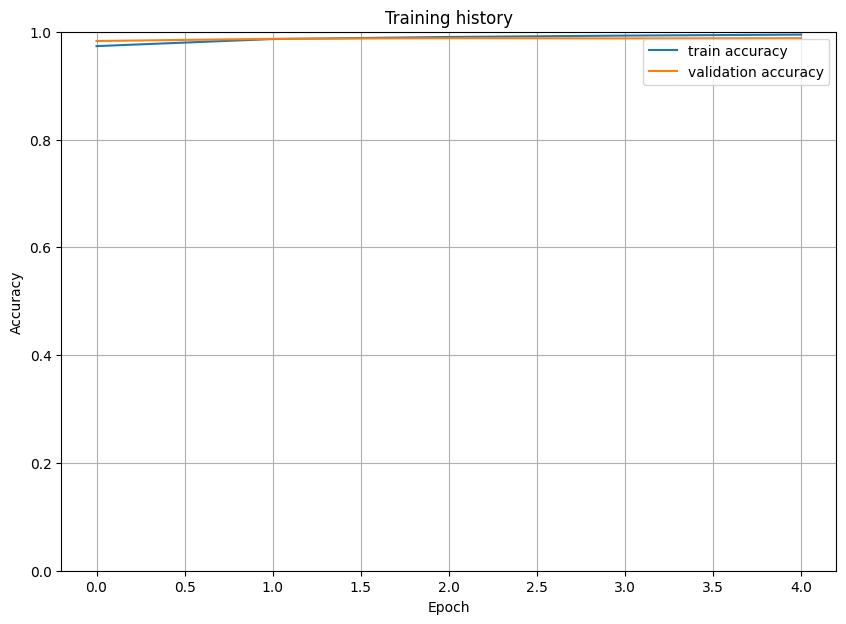

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

In [ ]:
# Load model
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(data_dir,"output","sdg_classification_model_state.bin")))
model = model.to(device)

In [ ]:

# to evaluate using test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [ ]:
test_acc

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions -
    """
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values

In [ ]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)


In [ ]:
predictions.numpy()

In [ ]:
print(classification_report(target_values, predictions, target_names=target_list))

In [ ]:
raw_text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum. "

In [ ]:

encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [ ]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)

output = torch.sigmoid(output).detach().cpu()

output = output.flatten().round().numpy()
output

In [ ]:

print(f"Title: {raw_text}")
for idx, p in enumerate(output):
  if p==1:
    print(f"Label: {target_list[idx]}")